In [3]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
import flax
from typing import Any
import numpy as np

# Optimizers

Within the umbrella of gradient descent, there are many varieties of strategies we can choose from. We usually refer these update choices as **optimizers**, which often take the form of modifying the gradient in some way to stabilize learning.

## Gradient Descent

The simplest optimization strategy is just **gradient descent**. The idea is to iteratively query the gradient, then update the parameters to move slightly in that direction. Remember that we want to minimize loss, so we want to move in the *negative* direction of the gradient.

Gradients represent the *first-order* behavior of the function, so gradients are only accurate around a local neighborhood of the parameters. A nice analogy is to think about descending down a parabola by moving in its tangent line. The tangent is constantly changing, so we need to keep re-calculating our gradient as we update the parameters.

```python
# Gradient Descent
grads = grad(params, x, y)
params = params - grads 
```

Note that the larger of a step we take, the more inaccurate our gradient direction is. To accomodate for this, we will use a small learning rate and update by that amount instead. Common learning rates for deep learning are around the `0.0001 - 0.01` range.
```python
# Gradient Descent with learning rate.
grads = grad(params, x, y)
params = params - grads * lr 
```


## Stochastic Gradient Descent

In machine learning we'll typically have a large dataset of `x, y` pairs, and define our loss function to minimize some prediction error over `y`. This dataset is often so big that it's unreasonable to try and calculate predictions over the entire dataset at once. Instead, we can sample random pairs from the dataset, and optimize the approximate loss we get from these pairs. This algorithm, known as **stochastic gradient descent (SGD)**, gives us an estimate of the true gradient at each step. What we lose in accuracy we gain in computation time: SGD operates on small batches that fit on the GPU, and can make more gradient updates per operation.

```python
x_batch, y_batch = sample(x, y)
grads = grad(params, x_batch, y_batch)
params = params - grads * lr # Stochastic Gradient Descent
```

## Choosing the learning rate

The learning rate is intuitively defines a local neighborhood over parameters where we assume our gradient is correct. Even for very simple functions, choosing the correct learning rate is important. 

Let's look at a simple gradient descent plot. Here, our parameters are `(x,y)` and we are using a quadratic loss function.

In [200]:
def plot_optim(optim):
    theta = np.pi / 16
    eigenvalues = np.array([1, 6])
    Q = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]]) @ np.diag(eigenvalues) @ np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])

    @jax.vmap
    def quadratic_loss(v):
        return v.T @ Q @ v

    iter_points = []
    z = np.array([9.5, -1])
    for i in range(50):
        iter_points.append(z)
        grad_z = Q @ z
        z = optim(z, grad_z)

    # Create a grid of points
    x = np.linspace(-10, 10, 100)
    y = np.linspace(-4, 4, 100)
    X, Y = np.meshgrid(x, y)
    XY = np.stack([X.flatten(), Y.flatten()], axis=-1)
    Z = quadratic_loss(XY)
    Z = Z.reshape(X.shape)

    # Create the plot
    plt.figure(figsize=(10, 4))
    contour = plt.contour(X, Y, Z, levels=50, cmap='viridis', alpha=0.4)
    plt.clabel(contour, inline=True, fontsize=8)


    iter_points = np.array(iter_points)
    plt.plot(iter_points[:, 0], iter_points[:, 1], 'ro-')
    plt.xticks([])
    plt.yticks([])
    plt.show()

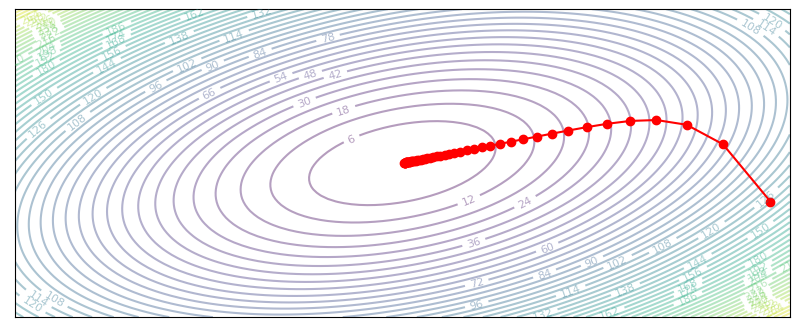

In [155]:
def gradient_descent(z, grad_z):
    return z - 0.1 * grad_z
plot_optim(gradient_descent)

If our learning rate is too low, the network will take a long time to reach the minimum point. Slow convergence is especially true for mean-squared error loss functions, as the gradient magnitude approaches zero along with the loss. 

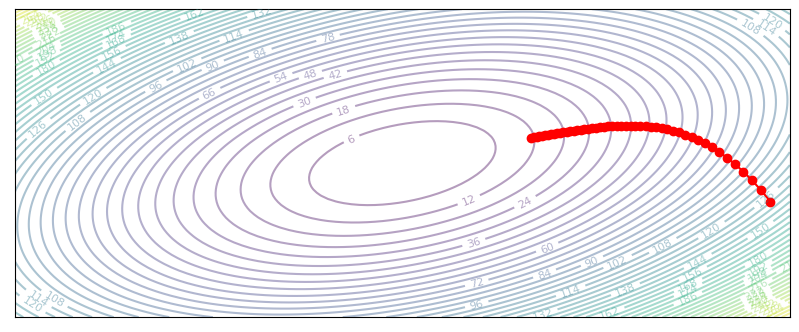

In [158]:
def gradient_descent_slow(z, grad_z):
    return z - 0.02 * grad_z
plot_optim(gradient_descent_slow)

On the other hand, a high learning rate means we will overshoot our optimal parameters. If the update overshoots by less than 2x, the network will still eventually converge, but will oscillate between directions and have an overall slower convergence. If the update overshoots by more than 2x, the parameters will completely diverge and approach infinity. Both of these are not great.

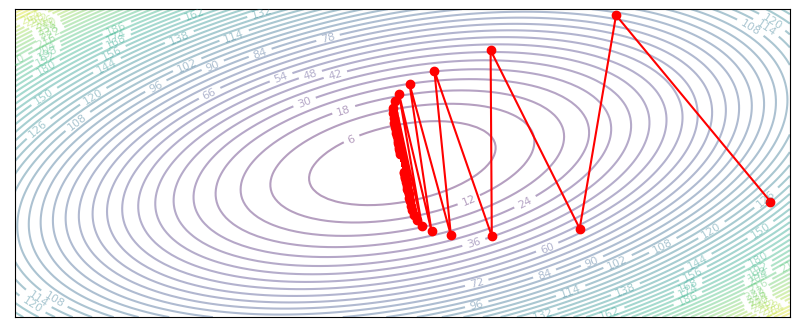

In [180]:
def gradient_descent_oscillate(z, grad_z):
    return z - 0.325 * grad_z
plot_optim(gradient_descent_oscillate)

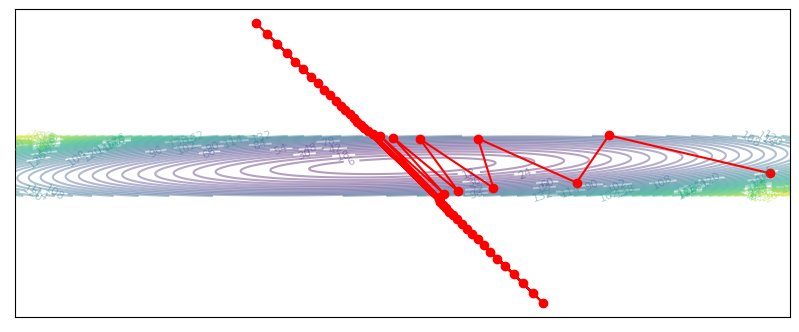

In [166]:
def gradient_descent_diverge(z, grad_z):
    return z - 0.34 * grad_z
plot_optim(gradient_descent_diverge)

## Learning rate in terms of eigenvalues

For our simple quadratic loss function, we can actually identify the exact optimal learning rate. Let's start by examining our cost matrix Q. We've defined Q to be a `2x2` matrix, with eigenvalues `1` and `6`.

We can rewrite $Q$ as $R \Sigma R^T$ equivalently, where $R$ contains the two eigenvectors of $Q$.

In [170]:
theta = np.pi / 16
eigenvalues = np.array([1, 6])
R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
Q = R @ np.diag(eigenvalues) @ R.T

eigenvalues, eigenvectors = np.linalg.eig(Q)

print('Q:', Q)
print('Eigenvalues:', eigenvalues)
print('Eigenvectors (R):', eigenvectors)

Q: [[ 1.19030117 -0.95670858]
 [-0.95670858  5.80969883]]
Eigenvalues: [1. 6.]
Eigenvectors (R): [[-0.98078528  0.19509032]
 [-0.19509032 -0.98078528]]


Let's take a closer look at what gradient descent is doing at each step. We'll use $y = R^Tx$ to represent a projection of $x$ onto the eigenvector space:

$$
\begin{align}
x' & = x - \alpha \nabla x^T Q x \\
& = x - \alpha Q x \\
& = x - \alpha R \Lambda R^T x \\
& = Ry - \alpha R \Lambda R^T Ry \\
& = R(y - \alpha \Lambda y) \\
& = R (I - \alpha \Lambda) y.
\end{align}
$$

Look at that! At each gradient step, each component of $y$ decreases exponentially by the rate of $(1 - \alpha \lambda)$. 

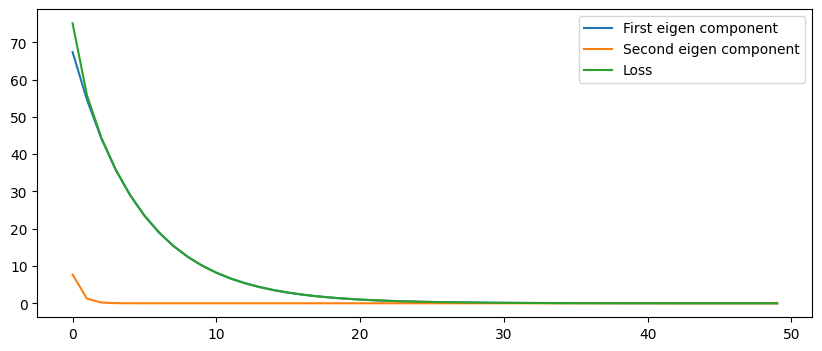

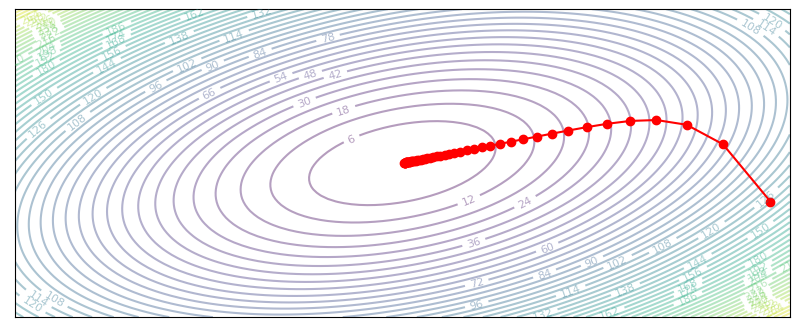

In [209]:
ys = []
loss = []
x = np.array([9.5, -1])
for i in range(50):
    grad_x = Q @ x
    x = x - 0.1 * grad_x
    ys.append(eigenvectors.T @ x)
    loss.append(x.T @ Q @ x)

# Plot the trajectory
ys = np.array(ys)
plt.figure(figsize=(10, 4))
loss_1 = np.square(ys[:, 0]) * np.abs(eigenvalues[0])
loss_2 = np.square(ys[:, 1]) * np.abs(eigenvalues[1])
plt.plot(loss_1, label='First eigen component')
plt.plot(loss_2, label='Second eigen component')
plt.plot(loss, label='Loss')
plt.legend()
plt.show()

def gradient_descent(z, grad_z):
    return z - 0.1 * grad_z
plot_optim(gradient_descent)

**Fig Above**: In our quadratic cost function, each eigenvector is an axis of the ellipse. The orange curve represents our point quickly approaching the wide axis, then the blue curve shows our point slowly converging along the second axis.

We want to reach $y=0$ (and therefore $x=0$) to minimize cost, so we are bounded by the slowest moving component of $y$. We want the slowest $|1 - \alpha|$ to be the maximum value it can be (so we learn fast), *without* letting any $ |1 - \alpha \lambda|$ be greater than one (or we will diverge). For our $Q$ matrix, this means our learning rate should be:

In [177]:
print('Optimal LR is', 2 / (np.max(eigenvalues) + np.min(eigenvalues)))

Optimal LR is 0.2857142857142857


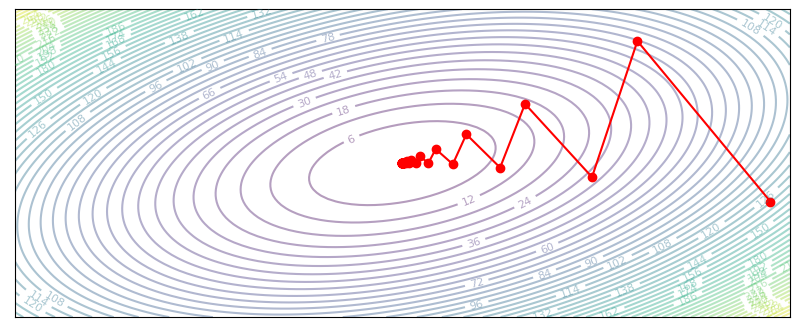

In [178]:
def gradient_descent(z, grad_z):
    return z - 0.28 * grad_z
plot_optim(gradient_descent)

## Momentum

There's another trick we use to stabilize learning (and therefore increase our learning rate safely) -- we can follow an average of *past* gradients, which we call **momentum**. We can keep track of an exponential moving average of the gradient by introducing a new momentum state $m$:

$$
m' \leftarrow \Beta m + \nabla f(x)
x' \leftarrow x' - \alpha m'
$$



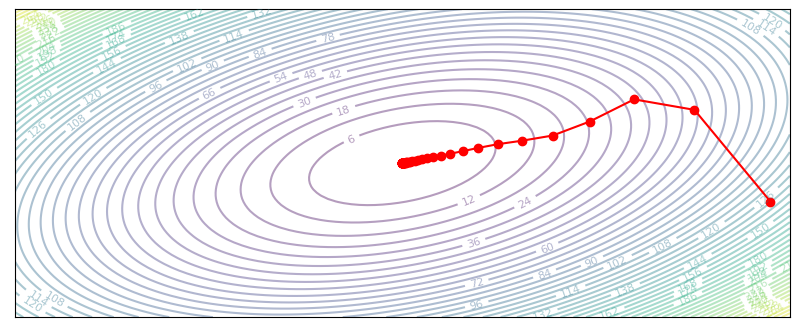

In [229]:
class Momentum:
    def __init__(self):
        self.beta = 0.17
        # self.beta = 0
        self.m = np.zeros(2)

    def step(self, z, grad_z):
        self.m = self.beta * self.m + grad_z
        return z - 0.16 * self.m

m = Momentum()
plot_optim(m.step)

In [226]:
l1 = np.sqrt(np.max(eigenvalues))
l2 = np.sqrt(np.min(eigenvalues))

print('Optimal LR is', (2 / (l1 + l2)**2))

print('Optimal B is', ((l1 - l2)/(l1 + l2))**2)

Optimal LR is 0.16808164115469154
Optimal B is 0.17657148808284048
